# Developer-Doku Training Step-by-Step

Im Folgenden JupyterNotebook soll die Datenaufbereitung sowie der Trainingsprozess Schritt für Schritt anhand des Codes erklärt werden.

In [44]:
# for data
from statsmodels.graphics.api import abline_plot
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for statistical tests
import statsmodels.formula.api as smf
import statsmodels.api as sm

# for machine learning
from sklearn import model_selection, ensemble, metrics

# for model persistence
import pickle

# for files
import os.path

# for date
import datetime

# for HTTP
import requests

# for weather
import meteostat as met
from geopy.geocoders import Nominatim

## Daten einlesen
Daten werden aus `.csv`-Datei eingelesen.

In [4]:
dtf = pd.read_csv("../data/mobilityData.csv")

## Spalten selektieren
Nur die für den weiteren Prozess relevanten Spalten werden beibehalten.

In [5]:
dtf.columns = dtf.columns.str.strip()
cols = ["Bucket", "StartId", "StartName", "EndId", "EndName", "Count"]
dtf = dtf[cols]

## Besucherzahlen aggregieren
Besucherströme, welche am selben Tag in den selben Ziellandkreis erfolgen, werden zusammengefasst.

In [6]:
dtf = dtf[dtf['Bucket'].str.len() == 10]
dtf = dtf.groupby(["Bucket", "EndId", "EndName"])[
    "Count"].sum().reset_index()

## Wochentage hinzufügen
Der entsprechende Wochentag jedes einzelnen Datensatzes wird hinzugefügt.

In [7]:
dtf["DoW"] = dtf["Bucket"].apply(
    lambda bucket: pd.to_datetime(bucket).day_name())

## Zeitraum begrenzen
Aufgrund von nicht zu berücksichtigenden Abweichungen im Mobilitätsverhalten, welche durch die Corona-Maßnahmen im Jahr 2020 hervorgerufen wurden, werden für das Training lediglich die Datensätze ab dem 01.04.2020 verwendet.

In [8]:
dtf = dtf[dtf['Bucket'] >= '2020-04-01']

## Nomenklatur anpassen
Die "Zielspalte" (`Count` = Besucheranzahl) wird gemäß der gängigen Nomenklatur im Machine Learning Kontext in `Y` umbenannt.

In [9]:
dtf = dtf.rename(columns={"Count": "Y"})

## Landkreise extrahieren
Aus den bestehenden Daten werden alle auftretenden Ziellandkreise extrahiert.

In [10]:
districts = dtf[['EndId', 'EndName']].copy()
districts.drop_duplicates(subset = ["EndId"], inplace=True)

## Landkreiskoordinaten ermitteln
Für jeden extrahierten Landkreis werden über die `geopy`-Bibliothek (siehe `Doku_developer external_data.md`) Koordinaten basierend auf dem Landkreisnamen ermittelt. Landkreisnamen, für die keine Koordinaten ermittelt werden können werden in einer Fehlermeldung genannt und der Datensatz übersprungen.

In [13]:
geolocator = Nominatim(user_agent="hke-tgki/0.1")

districts["Lat"] = ""
districts["Lon"] = ""

for i in districts.index:
    location = geolocator.geocode(districts['EndName'][i])
    
    if (location == None):
        print("Could not find coordinates for district: " + districts['EndName'][i])
        continue

    if (location.latitude == None or location.longitude == None): continue

    districts.loc[i,'Lat'] = location.latitude
    districts.loc[i,'Lon'] = location.longitude

Could not find coordinates for district: Rostock - Ortsbeirat 18 : Gehlsdrf,Hinrichsdorf,Jürgenshof,Krummendorf,Nienhagen,Peez,Stuthof


## Fehlerhafte Landkreisdaten entfernen
Landkreise, welche fehlerhafte Daten enthalten, werden entfernt.

In [19]:
print("Rows before NaN removal: ", districts.shape[0])
districts.replace([np.inf, -np.inf], np.NaN, inplace=True)
districts.replace("", np.NaN, inplace=True)
districts.dropna(how='any', axis=0, inplace=True)
print("Rows after NaN removal: ", districts.shape[0])

506

506

## Landkreisdaten speichern
Alle ermittelten Landkreisdaten werden in einer `.csv`-Datei gespeichert, um bei einem späteren Training oder eine Prognose darauf zugreifen zu können.

In [20]:
districts.to_csv("../data/districts.csv")

## Wetterdaten für Landkreise laden
Für jeden Landkreis werden vom Datum des ersten Datensatzes bis zum Datum des letzten Datensatzes der Mobilitätsdaten die entsprechenden Wetterdaten für den Landkreis abgefragt (siehe `Doku_developer external_data.md`) und im `districts`-Dataframe zwischengespeichert.
Dies passiert aus Gründen der Performanz, da es performanter ist, wenige Anfragen für jeweils größere Zeiträume zu tätigen (eine Anfrage pro Landkreis für gesamten Zeitraum) als viele Anfragen für jeweils nur einen Tag (einzelne Anfragen für jeden Datensatz, sprich für jede Tag-Landkreis-Kombination in den Mobilitätsdaten).

In [21]:
class WeatherData: 
    def __init__(self, data): 
        self.data = data

districts["Weather"] = ""
start = datetime.datetime.strptime(dtf.iloc[1]['Bucket'], "%Y-%m-%d")
end = datetime.datetime.strptime(dtf.iloc[-1]['Bucket'], "%Y-%m-%d")

for i in districts.index:
    districts.loc[i,'Weather'] = WeatherData(met.Daily(met.Point(districts['Lat'][i], districts['Lon'][i]), start, end).fetch())

## Wetterdaten für alle Mobilitätsdatensätze hinzufügen
Für jeden Mobilitätsdatensatz im `dtf`-Dataframe werden nun die entsprechenden Wetterdaten für Tag und Landkreis herausgesucht, welche im vorangegangenen Schritt im `districts`-Dataframe gespeichert wurden. Diese Wetterdaten werden direkt zum entsprechenden Mobilitätsdatensatz hinzugefügt.
In diesem Fall handelt es sich um zwei Wetterkennzahlen: `MaxTemp` = Höchsttemperatur in °C, `Precip` = Niederschlagsmenge in mm

In [25]:
dtf["MaxTemp"] = ""
dtf["Precip"] = ""

for i in dtf.index:
    id = dtf.loc[i, 'EndId']
    time = dtf.loc[i, 'Bucket']
    if(districts.loc[(districts.EndId == id),'Weather'].empty): continue
    weatherData = districts.loc[(districts.EndId == id),'Weather'].values[0]

    if(weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time))].size < 1):
        continue

    dtf.loc[i, 'MaxTemp'] = weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time)), 'tmax'].values[0]
    dtf.loc[i, 'Precip'] = weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time)), 'prcp'].values[0]

## Ungültige Datensätze entfernen
Alle jetzt im `dtf`-Dataframe enthaltenen Mobilitätsdatensätze, welche in mindestens einer Spalte ungültige Werte beinhalten werden in diesem Schritt entfernt.

In [26]:
# Remove invalid values
print("Rows before NaN removal: ", dtf.shape[0])
dtf.replace([np.inf, -np.inf], np.NaN, inplace=True)
dtf.replace("", np.NaN, inplace=True)
dtf.dropna(how='any', axis=0, inplace=True)
print("Rows after NaN removal: ",dtf.shape[0])

Rows before NaN removal:  95418
Rows after NaN removal:  94484


## Tage klassifizieren
Gemäß des jeweiligen Wochentags bekommt jeder Datensatz in einer zusätzlichen Spalte `Day_class` den Wert `free` (Samstag, Sonntag) oder `work` (Montag, Dienstag, Mittwoch, Donnerstag, Freitag) zugewiesen.

In [27]:
Day_clusters = {"free": ["Saturday", "Sunday"], "work": ["Monday", "Tuesday", "Wednesday",
                                                         "Thursday", "Friday"]}

dic_flat = {v: k for k, lst in Day_clusters.items() for v in lst}

for k, v in Day_clusters.items():
    if len(v) == 0:
        residual_class = k
        
dtf["Day_class"] = dtf['DoW'].apply(lambda x: dic_flat[x] if x in
                                   dic_flat.keys() else residual_class)

## Feiertage laden
Feiertage für das Jahr des ersten Mobilitätsdatensatzes werden über HTTPS-Request geladen (siehe `Doku_developer external_data.md`) und die entsprechenden Daten der Feiertage extrahiert.

In [28]:
year = dtf['Bucket'].iloc[0][:4]

# Request free days from Feiertage API for year 2021 in bavaria
free_days_json = requests.get(
    f'https://feiertage-api.de/api/?jahr={year}&nur_land=BY')

# Parse result and store as [key, val] dict
free_days_json = free_days_json.json()

free_days = []

# Iterate over
for free_day_name in free_days:
    free_days.append(free_days_json[free_day_name]['datum'])

## Feiertage in Klassifikation aufnehmen
Für alle Daten, die zuvor als Feiertage ermittelt wurden, wird die Klassifikation in der Spalte `Day_class` auf `free` geändert.

In [29]:
for day in free_days:
    dtf.loc[(dtf.Bucket == day), 'Day_class'] = 'free'

## Ferienzeiträume laden
Ferienzeiträume für das Jahr des ersten Mobilitätsdatensatzes werden über HTTPS-Request geladen (siehe `Doku_developer external_data.md`). Gespeichert wird hierbei jeweils das Datum des ersten und letzten Ferientags.

In [30]:
year = dtf['Bucket'].iloc[0][:4]

# Request free days from Feiertage API for year in bavaria
holidays = requests.get(
f'https://ferien-api.de/api/v1/holidays/BY/{year}')

# Parse result and store as [key, val] dict
holidays = holidays.json()

holiday_dates = []

# Iterate over
for holiday in holidays:
    holiday_dates.append((holiday['start'], holiday['end']))

## Reisetage identifizieren
Ausgehend von den angefragten Ferienzeiträumen werden nun die entsprechenden Reisetage ermittelt. Hierbei werden jeweils die ersten x Tage ab dem ersten Ferientag (`start + timespan`) sowie die letzten x Tage vor dem letzten Ferientag (`end - timespan`) als Reisetage betrachtet und die entsprechenden Daten ermittelt.

In [31]:
timespan = 4

travellingDays = []

for date in holiday_dates:
    start = datetime.datetime.strptime(date[0], "%Y-%m-%dT%H:%MZ")
    end = datetime.datetime.strptime(date[1], "%Y-%m-%dT%H:%MZ")
    for i in range(0, timespan-1, 1):
        travellingDays.append(datetime.datetime.strftime(start + datetime.timedelta(days=i), "%Y-%m-%d"))
        travellingDays.append(datetime.datetime.strftime(end - datetime.timedelta(days=i),"%Y-%m-%d" ))

## Reisetage in Klassifikation aufnehmen
Es wird eine neue Spalte `Day_class_travel` angelegt, deren Werte für alle Datensätze deren Datum in `travellingDays` enthalten ist `= 1` gesetzt wird (sonst `= 0`).

In [32]:
dtf['Day_class_travel'] = 0
for day in travellingDays:
    dtf.loc[(dtf.Bucket == day), 'Day_class_travel'] = 1

## One-Hot-Encoding
Spalten, welche qualitative Werte enthalten (`Day_class, DoW, EndId`) werden im Folgenden One-Hot-Encodiert.

In [33]:
# create dummies Day_class
dummy = pd.get_dummies(dtf["Day_class"],
                       prefix="Day_class", drop_first=True)
dtf = pd.concat([dtf, dummy], axis=1)
    
# drop the original column
dtf = dtf.drop("Day_class", axis=1)


# create dummies DoW
dummy = pd.get_dummies(dtf["DoW"],
                       prefix="DoW", drop_first=False)
dtf = pd.concat([dtf, dummy], axis=1)

# drop the original column
dtf = dtf.drop("DoW", axis=1)


# create dummies EndId
dummy = pd.get_dummies(dtf["EndId"],
                       prefix="EndId", drop_first=False)
dtf = pd.concat([dtf, dummy], axis=1)


## Aufbereitete Daten speichern
Die fertig aufbereiteten Daten werden als `.csv` gespeichert, um sie für zukünftige Trainingsdurchgänge oder als Vorlage für die Datenstruktur im Falle einer Prognose verfügbar zu haben.

In [34]:
dtf.to_csv("../data/mobilityData_complete.csv")

## Daten auf relevante Features reduzieren
In diesem Schritt werden die für den Lernprozess relevanten Spalten ("Features") festgelegt und die Daten auf diese Features reduziert.

In [35]:
# define training and test features
DoWColumns = [col for col in dtf if col.startswith('DoW_')]
DayColumns = [col for col in dtf if col.startswith('Day_')]
WeatherColumns = ["MaxTemp", "Precip"]
EndIdColumns = [col for col in dtf if col.startswith('EndId_')]
X_names = DoWColumns + DayColumns + EndIdColumns + WeatherColumns

relevantDtf = dtf[X_names + ["Y"]]

## Aufteilung Training & Test
Die Daten der relevanten Features werden in Trainings- (80%) und Testdaten (20%) unterteilt.

In [36]:
# split data
dtfTrain, dtfTest = model_selection.train_test_split(relevantDtf,
                                                     test_size=0.2)

## Trennung Features & Y
Die Features werden von den später zu prognostizierenden Besucherzahlen (`Y`) getrennt.

In [37]:
X_train = dtfTrain[X_names].values
Y_train = dtfTrain["Y"].values

X_test = dtfTest[X_names].values
Y_test = dtfTest["Y"].values

## Model festlegen
Als zu verwendendes Model wird der `GradientBoostingRegressor` der Bibliothek `Scikit learn` mit den durch Testläufe ermittelten besten Parametern festgelegt.

In [38]:
model = ensemble.GradientBoostingRegressor(n_estimators=400, random_state=21)

## Training
Das Model wird anhand der Trainingsdaten trainiert.

In [39]:
model.fit(X_train, Y_train)

GradientBoostingRegressor(n_estimators=400, random_state=21)

## Model speichern
Um in Zukunft auf des fertig trainierte Model zurückzugreifen zu können (bspw. für die Erstellung einer Prognose) wird dieses in einer Datei gespeichert.

In [40]:
pickle.dump(model, open("mobilityPredictionModel.sav", 'wb'))

## Testprognose
Anhand der Features der Testdaten (welche **nicht** zum Training des Models verwendet wurden) werden vom Model entsprechende Besucherzahlen für diese Features prognostiziert.

In [41]:
predicted = model.predict(X_test)

## Testprognosenkennzahlen
Hier werden verschiedene Kennzahlen zur Testprognose abgegeben, welche Aufschluss darüber geben können, wie stark die prognostizierten Besucherzahlen von den realen abweichen.

Mean Absolute Error (Σ|y-pred|/n): 854
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 7,010
Max Error: -266,629
Max Error Dataset:
           Bucket    EndId       Y
38108  2020-04-18  6253300  186671


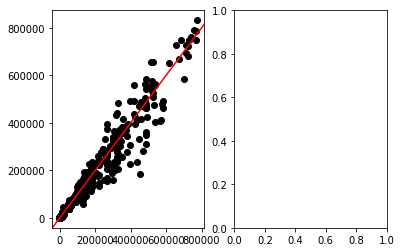

[Text(0.5, 3.1999999999999993, 'Predicted'),
 Text(3.200000000000003, 0.5, 'True'),
 Text(0.5, 1.0, 'Predicted vs True')]

[Text(0.5, 3.1999999999999993, 'Predicted'),
 Text(207.56818181818176, 0.5, 'Residuals'),
 Text(0.5, 1.0, 'Predicted vs Residuals')]

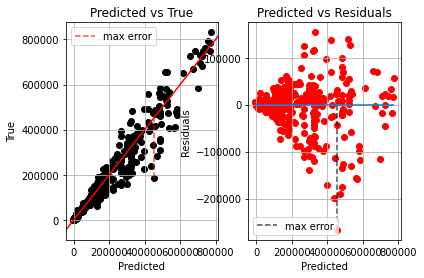

In [46]:
# Print errors
print("Mean Absolute Error (Σ|y-pred|/n):",
        "{:,.0f}".format(metrics.mean_absolute_error(Y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):",
        "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(Y_test, predicted))))

# Print residuals
residuals = Y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(
    min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(
    min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = Y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))


# Get dataset that has biggest error
max_difference_y = 0
max_dif = 0
for idx, val in enumerate(Y_test):
    dif = abs(val - predicted[idx])
    if(dif > max_dif):
        max_dif = dif
        max_difference_y = val
print("Max Error Dataset:")
print(dtf.loc[dtf['Y'] == max_difference_y, ["Bucket", "EndId", "Y"]])


# Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(predicted, Y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error,
                color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()

# Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black',
                linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals",
            title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()